In [ ]:
# %pip install scipy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tqdm import tqdm

from scipy.spatial import ConvexHull

import lsst.daf.butler as dafButler
import  lsst.geom as geom
from lsst.geom import Point2I, Point2D

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')

In [ ]:
def get_lsst_cutout(butler, visit_id, detector_id, ra, dec, size=100, instrument="LSSTComCam"):
    """
    Extracts and visualizes an image cutout from LSST data using a Butler.

    Parameters:
    -----------
    butler : lsst.daf.butler.Butler
        The data butler instance.
    visit_id : int
        The LSST visit ID.
    detector_id : int
        The detector ID.
    ra : float
        Right Ascension (RA) in degrees.
    dec : float
        Declination (Dec) in degrees.
    size : int, optional
        The size of the cutout (default: 100 pixels).
    instrument : str, optional
        The LSST instrument name (default: "LSSTComCam").

    Returns:
    --------
    None
        Displays a plot of the extracted image cutout.
    """

    # Load the full image
    full_image = butler.get(
        'calexp',
        visit=visit_id,
        detector=detector_id,
        instrument=instrument,
    )

    # Get WCS and convert sky coordinates to pixel coordinates
    wcs = full_image.getWcs()
    xy = geom.Point2D(wcs.skyToPixel(geom.SpherePoint(ra, dec, geom.degrees)))

    # Get detector bounding box
    detector_box = full_image.getDetector().getBBox()

    # Define cutout size and create a bounding box
    cutout_size = geom.Extent2I(size, size)
    cutout_box = geom.Box2I(geom.Point2I(xy) - cutout_size // 2, cutout_size)
    cutout_box = cutout_box.clippedTo(detector_box)

    # Extract the cutout
    cutout = butler.get(
        'calexp',
        visit=visit_id,
        detector=detector_id,
        instrument=instrument,
        parameters={'bbox': cutout_box},
    )

    # Convert to NumPy array
    image_array = cutout.getImage().getArray()

    # Apply ZScale normalization
    interval = ZScaleInterval()
    vmin, vmax = interval.get_limits(image_array)

    # Compute relative pixel position inside cutout
    cutout_origin = cutout_box.getMin()  # Bottom-left corner of cutout in full image
    xy_cutout = (xy.getX() - cutout_origin.getX(), xy.getY() - cutout_origin.getY())

    # Plot the image
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Create an axis divider for the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Reduce colorbar width

    im = ax.imshow(image_array, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')

    # Add red dot at (RA, Dec) transformed to cutout coordinates
    ax.scatter(xy_cutout[0], xy_cutout[1], color='red', s=50, marker='o', edgecolors='black', label="Target Position")

    # Add tighter colorbar
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label("Pixel Value")

    # Titles and labels
    ax.set_title(f"Visit {visit_id}, Detector {detector_id}, RA: {ra:.6f}, Dec: {dec:.6f}")
    ax.set_xlabel("X Pixels")
    ax.set_ylabel("Y Pixels")

    plt.show()

In [ ]:
# Load collection
repo = '/repo/main'
instrument = "LSSTComCam"
collection = 'LSSTComCam/runs/DRP/DP1/w_2025_04/DM-48556'
butler= dafButler.Butler(repo, collections=collection, instrument=instrument)

# older collections
repo_old = "embargo_new"

butler_50 = dafButler.Butler(repo_old, collections="LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128", instrument=instrument)
butler_49 = dafButler.Butler(repo_old, collections="LSSTComCam/runs/DRP/20241101_20241204/w_2024_49/DM-47988", instrument=instrument)
butler_48 = dafButler.Butler(repo_old, collections="LSSTComCam/runs/DRP/20241101_20241127/w_2024_48/DM-47841", instrument=instrument)


In [ ]:
visit_id = 2024110900195
detector_id = 3

In [ ]:
# Retrieve exposure
exp = butler.get("calexp", visit=visit_id, detector=detector_id)

# Get WCS and compute sky footprint
wcs = exp.getWcs()
bbox = exp.getBBox()

# Convert pixel corners to celestial coordinates
corners = [wcs.pixelToSky(Point2D(p.getX(), p.getY())) for p in bbox.getCorners()]

# Load skymap
name_skymap = "lsst_cells_v1"
skymap = butler.get("skyMap", skymap=name_skymap, collections="skymaps")

# Find tract and patch
for tract_info in skymap:
    # Check if ANY corner is inside the tract
    corners_in_tract = [corner for corner in corners if tract_info.contains(corner)]
    
    if corners_in_tract:  # Only process if at least one corner is inside the tract
        print(f"Tract: {tract_info.tract_id}")

        try:
            # Find patch using a corner that is confirmed to be inside the tract
            patch_info = tract_info.findPatch(corners_in_tract[0])
            print(patch_info)
        except LookupError:
            print(f"Warning: Coordinate {corners_in_tract[0]} is not in tract {tract_info.tract_id}")
            break  # Break out of the loop if there's an issue

In [ ]:
corners

In [ ]:
radec = geom.SpherePoint(53.21167, -28.20111, geom.degrees)
tractInfo = skymap.findTract(radec)
patchInfo = tractInfo.findPatch(radec)
print(tractInfo, patchInfo)

In [ ]:
forcedSourceTable1 = butler.get('forcedSourceTable', dataId={'skymap': 'lsst_cells_v1','tract': 5063, 'patch': 4})


In [ ]:
src_1 = forcedSourceTable1.loc[190910612346244393]
src_2 = forcedSourceTable1.loc[191684656742008265]

In [ ]:
obj_1 = forcedSourceTable1[forcedSourceTable1['objectId'] == 2226748540758003742]

In [ ]:
obj_1_u = obj_1[obj_1['band'] == 'u']

In [ ]:
plt.scatter(obj_1_u['visit'], obj_1_u['psfFlux'].values)

In [ ]:
obj_1_u

In [ ]:
obj_id = 2226748540758003742

In [ ]:
src_1.visit

In [ ]:
mergedForcedSourceTable1 = butler.get('mergedForcedSource', dataId={'skymap': 'lsst_cells_v1','tract': 5063, 'detector': src_1.detector, "visit": src_1.visit})
mergedForcedSourceTable2 = butler.get('mergedForcedSource', dataId={'skymap': 'lsst_cells_v1','tract': 5063, 'detector': src_2.detector, "visit": src_2.visit})

In [ ]:
pd.set_option('display.max_rows', None)
mergedForcedSourceTable1.loc[obj_id]

In [ ]:
pd.set_option('display.max_rows', None)
mergedForcedSourceTable2.loc[obj_id]

In [ ]:
get_lsst_cutout(butler, src_1.visit, src_1.detector, src_1.coord_ra, src_1.coord_dec, size=60)

In [ ]:
get_lsst_cutout(butler, src_2.visit, src_2.detector, src_2.coord_ra, src_2.coord_dec, size=60)

In [ ]:
list_of_ap_flux = []
list_of_visits = []
list_of_psf_flux_area = []
list_of_psf_flux = []
for i in range(0, len(obj_1_u)):
    src_single = obj_1_u.iloc[i]
    mergedForcedSourceTable_single = butler.get('mergedForcedSource', dataId={'skymap': 'lsst_cells_v1','tract': 5063, 'detector': src_single.detector, "visit": src_single.visit})
    mergedForcedSourceTable_single_single_obj = mergedForcedSourceTable_single.loc[obj_id]
    list_of_visits.append(src_single.visit)
    list_of_ap_flux.append(mergedForcedSourceTable_single_single_obj['calexp']['base_CircularApertureFlux_12_0_instFlux'])
    list_of_psf_flux_area.append(mergedForcedSourceTable_single_single_obj['calexp']['slot_PsfFlux_area'])
    list_of_psf_flux.append(mergedForcedSourceTable_single_single_obj['calexp']['slot_PsfFlux_instFlux'])

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.scatter(np.arange(len(list_of_ap_flux)), list_of_ap_flux, label= 'base_CircularApertureFlux_12_0_instFlux')
plt.scatter(np.arange(len(list_of_ap_flux)), list_of_psf_flux, label = 'slot_PsfFlux_instFlux')
plt.legend()
plt.subplot(2, 1, 2)
plt.scatter(np.arange(len(list_of_ap_flux)), list_of_psf_flux_area, label = 'slot_PsfFlux_area')
plt.legend()


In [ ]:
# Colin Slater suggests to check if psfArea is wrong for the whole visit when is it wrong for one object

# let us look at only one visit



In [ ]:
mergedForcedSourceTable_single_single_obj

print(mergedForcedSourceTable_single_single_obj['calexp']['base_CircularApertureFlux_12_0_instFlux'])
print(mergedForcedSourceTable_single_single_obj['calexp']['slot_PsfFlux_area'])
print(mergedForcedSourceTable_single_single_obj['calexp']['slot_PsfFlux_instFlux'])

In [89]:
i = 5
src_single = obj_1_u.iloc[i]
mergedForcedSourceTable_single = butler.get('mergedForcedSource', dataId={'skymap': 'lsst_cells_v1','tract': 5063, 'detector': src_single.detector, "visit": src_single.visit})
mergedForcedSourceTable_single_single_obj = mergedForcedSourceTable_single.loc[obj_id]
print(src_single.detector, src_single.visit)

list_of_ap_flux_many_src=[]
list_of_psf_flux_area_many_src=[]
list_of_psf_flux_many_src=[]
for i in range(0, len(mergedForcedSourceTable_single)):
    mergedForcedSourceTable_single_single_obj = mergedForcedSourceTable_single.iloc[i]

    list_of_ap_flux_many_src.append(mergedForcedSourceTable_single_single_obj['calexp']['base_CircularApertureFlux_12_0_instFlux'])
    list_of_psf_flux_area_many_src.append(mergedForcedSourceTable_single_single_obj['calexp']['slot_PsfFlux_area'])
    list_of_psf_flux_many_src.append(mergedForcedSourceTable_single_single_obj['calexp']['slot_PsfFlux_instFlux'])

array_of_ap_flux_many_src_good_visit = np.array(list_of_ap_flux_many_src)
array_of_psf_flux_area_many_src_good_visit = np.array(list_of_psf_flux_area_many_src)
array_of_psf_flux_many_src_good_visit=np.array(list_of_psf_flux_many_src)

##############################################################################################################

i = 4
src_single = obj_1_u.iloc[i]
mergedForcedSourceTable_single = butler.get('mergedForcedSource', dataId={'skymap': 'lsst_cells_v1','tract': 5063, 'detector': src_single.detector, "visit": src_single.visit})
mergedForcedSourceTable_single_single_obj = mergedForcedSourceTable_single.loc[obj_id]
print(src_single.detector, src_single.visit)

list_of_ap_flux_many_src=[]
list_of_psf_flux_area_many_src=[]
list_of_psf_flux_many_src=[]
for i in range(0, len(mergedForcedSourceTable_single)):
    mergedForcedSourceTable_single_single_obj = mergedForcedSourceTable_single.iloc[i]

    list_of_ap_flux_many_src.append(mergedForcedSourceTable_single_single_obj['calexp']['base_CircularApertureFlux_12_0_instFlux'])
    list_of_psf_flux_area_many_src.append(mergedForcedSourceTable_single_single_obj['calexp']['slot_PsfFlux_area'])
    list_of_psf_flux_many_src.append(mergedForcedSourceTable_single_single_obj['calexp']['slot_PsfFlux_instFlux'])
 
array_of_ap_flux_many_src_bad_visit = np.array(list_of_ap_flux_many_src)
array_of_psf_flux_area_many_src_bad_visit = np.array(list_of_psf_flux_area_many_src)
array_of_psf_flux_many_src_bad_visit=np.array(list_of_psf_flux_many_src)

3 2024110900206
3 2024110900195


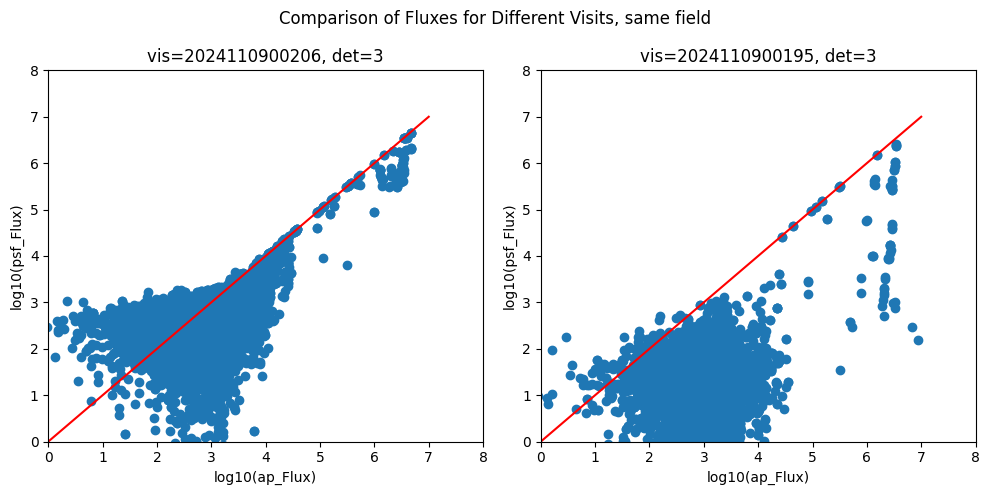

In [94]:
plt.figure(figsize=(10, 5))

# First subplot
plt.subplot(1, 2, 1)
plt.scatter(np.log10(array_of_ap_flux_many_src_good_visit), np.log10(array_of_psf_flux_many_src_good_visit))
plt.plot(np.arange(0, 8, 1), np.arange(0, 8, 1), color='red')
plt.xlabel('log10(ap_Flux)')
plt.ylabel('log10(psf_Flux)')
plt.title('vis=2024110900206, det=3')  # Title for first subplot
plt.xlim(0, 8)
plt.ylim(0, 8)

# Second subplot
plt.subplot(1, 2, 2)
plt.scatter(np.log10(array_of_ap_flux_many_src_bad_visit), np.log10(array_of_psf_flux_many_src_bad_visit))
plt.plot(np.arange(0, 8, 1), np.arange(0, 8, 1), color='red')
plt.xlabel('log10(ap_Flux)')
plt.ylabel('log10(psf_Flux)')
plt.title('vis=2024110900195, det=3')  # Title for second subplot
plt.xlim(0, 8)
plt.ylim(0, 8)

plt.suptitle('Comparison of Fluxes for Different Visits, same field')  # Figure-wide title
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()